# Initialization

In [1]:
from __future__ import print_function


from keras.models import Sequential, Model
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard,ReduceLROnPlateau
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.merge import concatenate
from keras.layers import AveragePooling2D, Multiply, Concatenate, Add

import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf
# from tqdm import tqdm
import numpy as np
import pickle

import os, cv2
from preprocessing import BatchGenerator
from utils import decode_netout, draw_boxes

# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

from keras.regularizers import l2
from keras.models import Model
from keras.applications.mobilenet import MobileNet
from keras.applications.xception import Xception
from keras.layers.merge import concatenate

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os


Using TensorFlow backend.


In [2]:
# from keras.applications.resnext import ResNeXt101

# resnext_m = ResNeXt101(include_top=False, weights='imagenet')
# keras.applications.resnext.ResNeXt101(include_top=True, weights='imagenet', input_shape=None)

In [3]:
# import keras

# # res_m = keras.applications.resnext.ResNeXt101(include_top=False, weights=None)


# xm = keras.applications.xception.Xception(include_top=False, weights=None, input_shape=(224,224,3))
# xm.output

In [4]:
# res_m = keras.applications.resnet50.ResNet50(include_top=False, weights=None, input_shape=(224,224,3))
# res_m.summary()

In [5]:
# xm.save_weights('xception-m.h5')

In [2]:
import xml.etree.ElementTree as ET

def parse_annotation(ann_dir, img_dir, labels=[]):
    all_imgs = []
    seen_labels = {}
    
    for ann in sorted(os.listdir(ann_dir)):
        img = {'object':[]}

        tree = ET.parse(ann_dir + ann)
        
        for elem in tree.iter():
            if 'filename' in elem.tag:
                img['filename'] = img_dir + elem.text
            if 'width' in elem.tag:
                img['width'] = int(elem.text)
            if 'height' in elem.tag:
                img['height'] = int(elem.text)
            if 'object' in elem.tag or 'part' in elem.tag:
                obj = {}
                
                for attr in list(elem):
                    if 'name' in attr.tag:
                        obj['name'] = attr.text

                        if obj['name'] in seen_labels:
                            seen_labels[obj['name']] += 1
                        else:
                            seen_labels[obj['name']] = 1
                        
                        if len(labels) > 0 and obj['name'] not in labels:
                            break
                        else:
                            img['object'] += [obj]
                            
                    if 'bndbox' in attr.tag:
                        for dim in list(attr):
                            if 'xmin' in dim.tag:
                                obj['xmin'] = int(round(float(dim.text)))
                            if 'ymin' in dim.tag:
                                obj['ymin'] = int(round(float(dim.text)))
                            if 'xmax' in dim.tag:
                                obj['xmax'] = int(round(float(dim.text)))
                            if 'ymax' in dim.tag:
                                obj['ymax'] = int(round(float(dim.text)))

        if len(img['object']) > 0:
            all_imgs += [img]
                        
    return all_imgs, seen_labels

In [3]:
train_image_folder = '../../coco-data/VOCdevkit/VOC2012/JPEGImages/'
train_annot_folder = '../../coco-data/VOCdevkit/VOC2012/Annotations/'

# valid_image_folder = '/home/ankish1/ankish_save/yolo/retinaNet/raccoon-data/val-images/'
# valid_annot_folder = '/home/ankish1/ankish_save/yolo/retinaNet/raccoon-data/val-annotations/'

train_imgs, seen_train_labels = parse_annotation(train_annot_folder, train_image_folder)


In [4]:
os.listdir('../../coco-data/VOCdevkit/VOC2012/')

['ImageSets',
 'Annotations',
 '2007_000129.jpg',
 'explore dataset.ipynb',
 '2007_000123.jpg',
 'JPEGImages',
 'SegmentationClass',
 '2007_000061.png',
 '2007_000042.png',
 'SegmentationObject',
 '2007_000170.png',
 '2007_000175.png',
 '.ipynb_checkpoints',
 '2007_000129.png']

In [5]:
import glob
seg_ = glob.glob('../../coco-data/VOCdevkit/VOC2012/SegmentationObject/*')
imgs_ = glob.glob('../../coco-data/VOCdevkit/VOC2012/JPEGImages/*')
ann_ =  glob.glob('../../coco-data/VOCdevkit/VOC2012/Annotations/*')

len(seg_), len(imgs_), len(ann_)

(2913, 17125, 17125)

In [6]:
len(list(seen_train_labels.keys())), seen_train_labels.values()

(23,
 dict_values([17401, 923, 1507, 643, 1002, 893, 704, 1059, 1598, 3056, 1271, 837, 1561, 1084, 800, 803, 801, 841, 771, 2492, 1277, 685, 1202]))

In [7]:
# df_test          = pd.read_csv('data/level3_data/test.csv')
# df               = pd.read_csv('data/level3_data/training_set.csv')

# train_dir        = 'data/train/images/'
# test_dir         = 'data/train/images/'
LABELS           = list(seen_train_labels.keys())#['obj']
BOX              = 5
CLASS            = len(LABELS)
wts              = list(seen_train_labels.values())
wts              = wts/np.sum(wts)
# CLASS_WEIGHTS    = wts.astype('float32')#np.ones(CLASS, dtype='float32')
CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')
OBJ_THRESHOLD    = 0.5
NMS_THRESHOLD    = 0.45

ANCHORS          = [1.99,4.15, 3.78,5.13, 4.78,2.38, 5.99,3.60, 6.15,5.81]

IMAGE_H, IMAGE_W = 224, 224
GRID_H,  GRID_W  = 7, 7
NO_OBJECT_SCALE  = 1.0
OBJECT_SCALE     = 5.0
COORD_SCALE      = 1.0
CLASS_SCALE      = 1.0
BATCH_SIZE       = 120
WARM_UP_BATCHES  = 0
TRUE_BOX_BUFFER  = 10#0

xception_wt_dir = 'xception-m.h5'

In [8]:
class BaseFeatureExtractor(object):
    """docstring for ClassName"""

    # to be defined in each subclass
    def __init__(self, input_size):
        raise NotImplementedError("error message")

    # to be defined in each subclass
    def normalize(self, image):
        raise NotImplementedError("error message")       

    def get_output_shape(self):
        return self.feature_extractor.get_output_shape_at(-1)[1:3]

    def extract(self, input_image):
        return self.feature_extractor(input_image)

    
class MobileNetFeature(BaseFeatureExtractor):
    """docstring for ClassName"""
    def __init__(self, input_size):
        input_image = Input(shape=(input_size, input_size, 3))

        mobilenet = MobileNet(input_shape=(224,224,3), include_top=False, weights=None)
        mobilenet.load_weights('mobile-net-yolo.h5')
        
        x = mobilenet(input_image)
        self.feature_extractor = Model(input_image, x)  

    def normalize(self, image):
        image = image / 255.
        image = image - 0.5
        image = image * 2.

        return image
    
class XceptionNetFeature(BaseFeatureExtractor):
    """docstring for ClassName"""
    def __init__(self, input_size):
        input_image = Input(shape=(input_size, input_size, 3))
        
        xceptionnet = Xception(input_shape=(224,224,3), include_top=False, weights=None)
        xceptionnet.load_weights(xception_wt_dir)
        x = xceptionnet(input_image)
        self.feature_extractor = Model(input_image, x)  

    def normalize(self, image):
        image = image / 255.
        image = image - 0.5
        image = image * 2.

        return image
 

In [9]:
input_size = 224
max_box_per_image = TRUE_BOX_BUFFER # ANCHORS * BOX
nb_box = BOX
nb_class = CLASS
    
input_image     = Input(shape=(input_size, input_size, 3), name='input_img')
true_boxes = Input(shape=(1, 1, 1, max_box_per_image , 4))  


def build_model(input_image, true_boxes):
    input_size = 224
    max_box_per_image = TRUE_BOX_BUFFER # ANCHORS * BOX
    nb_box = BOX
    nb_class = CLASS

    feature_extractor = XceptionNetFeature(input_size)

    # print(feature_extractor.get_output_shape())    
    grid_h, grid_w = feature_extractor.get_output_shape()        
    features = feature_extractor.extract(input_image)            
    ##################################################################

#     block_res11 = features

# #     features_ = BatchNormalization()(block_res1)
# #     features_ = Activation('relu')(features_)
#     features_ = Conv2D(512, (1, 1), 
#                        padding='same',
#                        kernel_initializer='he_normal',
#                        kernel_regularizer=l2(1e-4))(block_res11)
#     features_ = BatchNormalization()(features_)
#     features_ = Activation('relu')(features_)

#     features_ = Conv2D(512, (3, 3), 
#                        padding='same',
#                        kernel_initializer='he_normal',
#                        kernel_regularizer=l2(1e-4))(features_)
#     features_ = BatchNormalization()(features_)
#     features_ = Activation('relu')(features_)
#     #################################

# #     block_res2 = features_
#     features_ = Conv2D(2048, (1, 1), 
#                        padding='same',
#                        kernel_initializer='he_normal',
#                        kernel_regularizer=l2(1e-4))(features_)

#     print(block_res11, features_)
#     #################################
#     features_ = Add()([block_res11, features_])
    
    
    ##################################################################

    block_res1 = features

#     features_ = BatchNormalization()(block_res1)
#     features_ = Activation('relu')(features_)
    features_ = Conv2D(256, (1, 1), 
                       padding='same',
                       kernel_initializer='he_normal',
                       kernel_regularizer=l2(1e-4))(block_res1)
    features_ = BatchNormalization()(features_)
    features_ = Activation('relu')(features_)

    features_ = Conv2D(256, (3, 3), 
                       padding='same',
                       kernel_initializer='he_normal',
                       kernel_regularizer=l2(1e-4))(features_)
    features_ = BatchNormalization()(features_)
    features_ = Activation('relu')(features_)
    #################################

    block_res2 = features_
    features_ = Conv2D(1024, (1, 1), 
                       padding='same',
                       kernel_initializer='he_normal',
                       kernel_regularizer=l2(1e-4))(features_)

    #################################
    block_res1_m = Conv2D(1024, (1, 1), 
                       padding='same',
                       kernel_initializer='he_normal',
                       kernel_regularizer=l2(1e-4))(block_res1)
    features_ = Add()([block_res1_m, features_])
    ##################################################################
    
    

    features_ = Conv2D(256, (1, 1), 
                       padding='same',
                       kernel_initializer='he_normal',
                       kernel_regularizer=l2(1e-4))(features_)
    features_ = BatchNormalization()(features_)
    features_ = Activation('relu')(features_)

    features_ = Conv2D(256, (3, 3), 
                       padding='same',
                       kernel_initializer='he_normal',
                       kernel_regularizer=l2(1e-4))(features_)
    #################################

    new_block1 = features_
    features_ = BatchNormalization()(features_)
    features_ = Activation('relu')(features_)
    new_block2 = features_
    #################################

    
    #################################
    # channel attention

    c_global_feat = AveragePooling2D(pool_size=(7, 7))(new_block2)
    c_global_feat = Conv2D(256, (1, 1), 
                           padding='same',
                           kernel_initializer='he_normal',
                           kernel_regularizer=l2(1e-4))(c_global_feat)
    #     c_global_feat = BatchNormalization()(c_global_feat)
    c_global_feat = Activation('relu')(c_global_feat)

    c_global_feat = Conv2D(256, (1, 1), 
                           padding='same',
                           kernel_initializer='he_normal',
                           kernel_regularizer=l2(1e-4))(c_global_feat)
    c_global_feat = Activation('sigmoid')(c_global_feat)

    channel_weighted_feat = Multiply()([new_block2, c_global_feat])
    channel_weighted_feat = Conv2D(256, (1, 1), 
                                   padding='same',
                                   kernel_initializer='he_normal',
                                   kernel_regularizer=l2(1e-4))(channel_weighted_feat)
    #################################


    #################################
    # spatial attention

    s_global_feat = Conv2D(256, (1, 1), 
                           padding='same',
                           kernel_initializer='he_normal',
                           kernel_regularizer=l2(1e-4))(new_block2)
    s_global_feat = Activation('relu')(s_global_feat)

    s_global_feat = Conv2D(1, (1, 1), 
                           padding='same',
                           kernel_initializer='he_normal',
                           kernel_regularizer=l2(1e-4))(s_global_feat)
    s_global_feat = Activation('sigmoid')(s_global_feat)

    spatial_weighted_feat = Multiply()([new_block2, s_global_feat])
    spatial_weighted_feat = Conv2D(256, (1, 1), 
                                   padding='same',
                                   kernel_initializer='he_normal',
                                   kernel_regularizer=l2(1e-4))(spatial_weighted_feat)
    
    #################################


    #################################
    # concat both attention features

    concat_s_c_feat = Concatenate(axis=-1)([channel_weighted_feat, spatial_weighted_feat])
    concat_s_c_feat = Conv2D(256, (1, 1), 
                             padding='same',
                             kernel_initializer='he_normal',
                             kernel_regularizer=l2(1e-4))(concat_s_c_feat)

    final_feat = Add()([new_block1, concat_s_c_feat])

    #################################
    
    x = final_feat
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    ##################################################################
    # make the object detection layer
    output = Conv2D(nb_box * (4 + 1 + nb_class), 
                    (1,1), strides=(1,1), 
                    padding='same', 
                    name='DetectionLayer', 
                    kernel_initializer='lecun_normal')(x)#(features)
    output = Reshape((grid_h, grid_w, nb_box, 4 + 1 + nb_class))(output)

    model = Model([input_image, true_boxes], output)
    return model



In [10]:
def custom_loss(y_true, y_pred):
    mask_shape = tf.shape(y_true)[:4]
    
    cell_x = tf.to_float(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)))
    cell_y = tf.transpose(cell_x, (0,2,1,3,4))

    cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [BATCH_SIZE, 1, 1, BOX, 1])
    
    coord_mask = tf.zeros(mask_shape)
    conf_mask  = tf.zeros(mask_shape)
    class_mask = tf.zeros(mask_shape)
    
    seen = tf.Variable(0.)
    total_recall = tf.Variable(0.)
    
    """
    Adjust prediction
    """
    ### adjust x and y      
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid
    
    ### adjust w and h
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS, [1,1,1,BOX,2])
    
    ### adjust confidence
    pred_box_conf = tf.sigmoid(y_pred[..., 4])
    
#     ### adjust class probabilities
    pred_box_class = y_pred[..., 5:]
    
    """
    Adjust ground truth
    """
    ### adjust x and y
    true_box_xy = y_true[..., 0:2] # relative position to the containing cell
    
    ### adjust w and h
    true_box_wh = y_true[..., 2:4] # number of cells accross, horizontally and vertically
    
    ### adjust confidence
    true_wh_half = true_box_wh / 2.
    true_mins    = true_box_xy - true_wh_half
    true_maxes   = true_box_xy + true_wh_half
    
    pred_wh_half = pred_box_wh / 2.
    pred_mins    = pred_box_xy - pred_wh_half
    pred_maxes   = pred_box_xy + pred_wh_half       
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)
    
    true_box_conf = iou_scores * y_true[..., 4]
    
#     ### adjust class probabilities
    true_box_class = tf.argmax(y_true[..., 5:], -1)
    
    """
    Determine the masks
    """
    ### coordinate mask: simply the position of the ground truth boxes (the predictors)
    coord_mask = tf.expand_dims(y_true[..., 4], axis=-1) * COORD_SCALE
    
    ### confidence mask: penelize predictors + penalize boxes with low IOU
    # penalize the confidence of the boxes, which have IOU with some ground truth box < 0.6
    true_xy = true_boxes[..., 0:2]
    true_wh = true_boxes[..., 2:4]
    
    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half
    
    pred_xy = tf.expand_dims(pred_box_xy, 4)
    pred_wh = tf.expand_dims(pred_box_wh, 4)
    
    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half    
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)

    best_ious = tf.reduce_max(iou_scores, axis=4)
    conf_mask = conf_mask + tf.to_float(best_ious < 0.6) * (1 - y_true[..., 4]) * NO_OBJECT_SCALE
    
    # penalize the confidence of the boxes, which are reponsible for corresponding ground truth box
    conf_mask = conf_mask + y_true[..., 4] * OBJECT_SCALE
    
#     ### class mask: simply the position of the ground truth boxes (the predictors)
    class_mask = y_true[..., 4] * tf.gather(CLASS_WEIGHTS, true_box_class) * CLASS_SCALE       
    
    """
    Warm-up training
    """
    no_boxes_mask = tf.to_float(coord_mask < COORD_SCALE/2.)
    seen = tf.assign_add(seen, 1.)
    
    true_box_xy, true_box_wh, coord_mask = tf.cond(tf.less(seen, WARM_UP_BATCHES), 
                          lambda: [true_box_xy + (0.5 + cell_grid) * no_boxes_mask, 
                                   true_box_wh + tf.ones_like(true_box_wh) * np.reshape(ANCHORS, [1,1,1,BOX,2]) * no_boxes_mask, 
                                   tf.ones_like(coord_mask)],
                          lambda: [true_box_xy, 
                                   true_box_wh,
                                   coord_mask])
    
    """
    Finalize the loss
    """
    nb_coord_box = tf.reduce_sum(tf.to_float(coord_mask > 0.0))
    nb_conf_box  = tf.reduce_sum(tf.to_float(conf_mask  > 0.0))
    nb_class_box = tf.reduce_sum(tf.to_float(class_mask > 0.0))
    
    loss_xy    = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_wh    = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_conf  = tf.reduce_sum(tf.square(true_box_conf-pred_box_conf) * conf_mask)  / (nb_conf_box  + 1e-6) / 2.
    loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class)
    loss_class = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)
    
    loss = 3*loss_xy + 3*loss_wh + 2.5*loss_conf + 1.5*loss_class
    
    nb_true_box = tf.reduce_sum(y_true[..., 4])
    nb_pred_box = tf.reduce_sum(tf.to_float(true_box_conf > 0.5) * tf.to_float(pred_box_conf > 0.3))

    return loss

In [19]:
# BATCH_SIZE       = 5
generator_config['BATCH_SIZE'] = 90

In [20]:
generator_config = {
    'IMAGE_H'         : IMAGE_H, 
    'IMAGE_W'         : IMAGE_W,
    'GRID_H'          : GRID_H,  
    'GRID_W'          : GRID_W,
    'BOX'             : BOX,
    'LABELS'          : LABELS,
    'CLASS'           : len(LABELS),
    'ANCHORS'         : ANCHORS,
    'BATCH_SIZE'      : BATCH_SIZE,
    'TRUE_BOX_BUFFER' : TRUE_BOX_BUFFER,
}

In [12]:
def normalize(image):
    return image / 255.

In [13]:
len(train_imgs)

17125

In [14]:
idx = np.random.randint(len(train_imgs))
for i in train_imgs[idx]['object']:
    print(i['name'])

dog


In [15]:
train_imgs[idx]

{'object': [{'name': 'dog', 'xmax': 282, 'xmin': 1, 'ymax': 500, 'ymin': 51}],
 'filename': '../../coco-data/VOCdevkit/VOC2012/JPEGImages/2009_004772.jpg',
 'height': 500,
 'width': 375}

In [17]:
# train_imgs[:10]

(375, 500, 3)


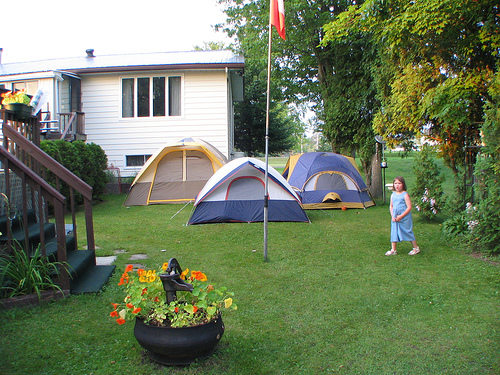

In [72]:
from PIL import Image
img_ = Image.open('../../coco-data/VOCdevkit/VOC2012/JPEGImages/2008_000564.jpg')
print(np.array(img_).shape)
img_

In [16]:
idx = np.random.permutation(len(train_imgs))
train_idx = idx[:16000] # do split according 
val_idx = idx[16000:]

train_imgs_ = [train_imgs[i] for i in train_idx]
# seen_train_labels = {}
# seen_train_labels['obj'] = len(train_imgs)

valid_imgs_ = [train_imgs[i] for i in val_idx]
# seen_valid_labels = {}
# seen_valid_labels['obj'] = len(valid_imgs)

len(train_imgs_), len(valid_imgs_)#, seen_train_labels, seen_valid_labels

(16000, 1125)

In [17]:
seen_train_labels = {}
seen_valid_labels = {}

for dt in valid_imgs_:
    for obj in dt['object']:
#         print(obj['name'])
        cls = obj['name']
        if cls not in seen_valid_labels:
            seen_valid_labels[cls] = 1
        else:
            seen_valid_labels[cls] += 1
            
for dt in train_imgs_:
    for obj in dt['object']:
#         print(obj['name'])
        cls = obj['name']
        if cls not in seen_train_labels:
            seen_train_labels[cls] = 1
        else:
            seen_train_labels[cls] += 1
            
len(seen_train_labels), len(seen_valid_labels)

(23, 23)

In [21]:
train_batch = BatchGenerator(train_imgs_, generator_config, norm=normalize)
valid_batch = BatchGenerator(valid_imgs_, generator_config, norm=normalize, jitter=False)

In [21]:
# class BatchGenerator(Sequence):
#     def __init__(self, images, 
#                        config, 
#                        shuffle=True, 
#                        jitter=True, 
#                        norm=None):
#         self.generator = None

#         self.images = images
#         self.config = config

#         self.shuffle = shuffle
#         self.jitter  = jitter
#         self.norm    = norm

#         self.anchors = [BoundBox(0, 0, config['ANCHORS'][2*i], config['ANCHORS'][2*i+1]) for i in range(int(len(config['ANCHORS'])//2))]

#         sometimes = lambda aug: iaa.Sometimes(0.5, aug)
#         self.aug_pipe = iaa.Sequential(
#             [
#                 iaa.Fliplr(0.5), # horizontally flip 50% of all images
# #                 sometimes(iaa.Crop(percent=(0, 0.8))), # crop images by 0-10% of their height/width
#                 sometimes(iaa.Affine(
#                 )),
#                 iaa.SomeOf((0, 5),
#                     [
#                         iaa.OneOf([
#                             iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
#                             iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
#                             iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
#                         ]),
#                         iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
#                         iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
#                         iaa.OneOf([
#                             iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
#                         ]),
#                         #iaa.Invert(0.05, per_channel=True), # invert color channels
#                         iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
#                         iaa.Multiply((0.5, 1.5), per_channel=0.5), # change brightness of images (50-150% of original value)
#                         iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
#                     ],
#                     random_order=True
#                 )
#             ],
#             random_order=True
#         )

#         if shuffle: np.random.shuffle(self.images)

#     def __len__(self):
#         return int(np.ceil(float(len(self.images))/self.config['BATCH_SIZE']))   

#     def num_classes(self):
#         return len(self.config['LABELS'])

#     def size(self):
#         return len(self.images)    

#     def load_annotation(self, i):
#         annots = []
#         for obj in self.images[i]['object']:
#             annot = [obj['xmin'], obj['ymin'], obj['xmax'], obj['ymax'], self.config['LABELS'].index(obj['name'])]
#             annots += [annot]
#         if len(annots) == 0: annots = [[]]
#         return np.array(annots)

    
#     def load_image(self, i):
#         return cv2.imread(self.images[i]['filename'])

#     def __getitem__(self, idx):
#         l_bound = idx*self.config['BATCH_SIZE']
#         r_bound = (idx+1)*self.config['BATCH_SIZE']

#         if r_bound > len(self.images):
#             r_bound = len(self.images)
#             l_bound = r_bound - self.config['BATCH_SIZE']

#         instance_count = 0

#         x_batch = np.zeros((r_bound - l_bound, self.config['IMAGE_H'], self.config['IMAGE_W'], 3))                         # input images
#         b_batch = np.zeros((r_bound - l_bound, 1     , 1     , 1    ,  self.config['TRUE_BOX_BUFFER'], 4))   # list of self.config['TRUE_self.config['BOX']_BUFFER'] GT boxes
#         y_batch = np.zeros((r_bound - l_bound, self.config['GRID_H'],  self.config['GRID_W'], self.config['BOX'], 4+1+len(self.config['LABELS'])))                # desired network output

#         for train_instance in self.images[l_bound:r_bound]:
#             # augment input image and fix object's position and size
#             img, all_objs = self.aug_image(train_instance, jitter=self.jitter)
            
#             # construct output from object's x, y, w, h
#             true_box_index = 0
            
#             for obj in all_objs:
#                 if obj['xmax'] > obj['xmin'] and obj['ymax'] > obj['ymin'] and obj['name'] in self.config['LABELS']:
#                     center_x = .5*(obj['xmin'] + obj['xmax'])
#                     center_x = center_x / (float(self.config['IMAGE_W']) / self.config['GRID_W'])
#                     center_y = .5*(obj['ymin'] + obj['ymax'])
#                     center_y = center_y / (float(self.config['IMAGE_H']) / self.config['GRID_H'])

#                     grid_x = int(np.floor(center_x))
#                     grid_y = int(np.floor(center_y))

#                     if grid_x < self.config['GRID_W'] and grid_y < self.config['GRID_H']:
#                         obj_indx  = self.config['LABELS'].index(obj['name'])
                        
#                         center_w = (obj['xmax'] - obj['xmin']) / (float(self.config['IMAGE_W']) / self.config['GRID_W']) # unit: grid cell
#                         center_h = (obj['ymax'] - obj['ymin']) / (float(self.config['IMAGE_H']) / self.config['GRID_H']) # unit: grid cell
                        
#                         box = [center_x, center_y, center_w, center_h]

#                         # find the anchor that best predicts this box
#                         best_anchor = -1
#                         max_iou     = -1
                        
#                         shifted_box = BoundBox(0, 
#                                                0,
#                                                center_w,                                                
#                                                center_h)
                        
#                         for i in range(len(self.anchors)):
#                             anchor = self.anchors[i]
#                             iou    = bbox_iou(shifted_box, anchor)
                            
#                             if max_iou < iou:
#                                 best_anchor = i
#                                 max_iou     = iou
                                
#                         # assign ground truth x, y, w, h, confidence and class probs to y_batch
#                         y_batch[instance_count, grid_y, grid_x, best_anchor, 0:4] = box
#                         y_batch[instance_count, grid_y, grid_x, best_anchor, 4  ] = 1.
#                         y_batch[instance_count, grid_y, grid_x, best_anchor, 5+obj_indx] = 1
                        
#                         # assign the true box to b_batch
#                         b_batch[instance_count, 0, 0, 0, true_box_index] = box
                        
#                         true_box_index += 1
#                         true_box_index = true_box_index % self.config['TRUE_BOX_BUFFER']
                            
#             # assign input image to x_batch
#             if self.norm != None: 
#                 x_batch[instance_count] = self.norm(img)
#             else:
#                 # plot image and bounding boxes for sanity check
#                 for obj in all_objs:
#                     if obj['xmax'] > obj['xmin'] and obj['ymax'] > obj['ymin']:
#                         cv2.rectangle(img[:,:,::-1], (obj['xmin'],obj['ymin']), (obj['xmax'],obj['ymax']), (255,0,0), 3)
#                         cv2.putText(img[:,:,::-1], obj['name'], 
#                                     (obj['xmin']+2, obj['ymin']+12), 
#                                     0, 1.2e-3 * img.shape[0], 
#                                     (0,255,0), 2)
                        
#                 x_batch[instance_count] = img

#             # increase instance counter in current batch
#             instance_count += 1  

#         #print(' new batch created', idx)

#         return [x_batch, b_batch], y_batch

#     def on_epoch_end(self):
#         if self.shuffle: np.random.shuffle(self.images)

#     def aug_image(self, train_instance, jitter):
#         image_name = train_instance['filename']
#         image = cv2.imread(image_name)

#         if image is None: print('Cannot find ', image_name)

#         h, w, c = image.shape
#         all_objs = copy.deepcopy(train_instance['object'])

#         if jitter:
#             ### scale the image
#             scale = np.random.uniform() / 10. + 1.
#             image = cv2.resize(image, (0,0), fx = scale, fy = scale)

#             ### translate the image
#             max_offx = (scale-1.) * w
#             max_offy = (scale-1.) * h
#             offx = int(np.random.uniform() * max_offx)
#             offy = int(np.random.uniform() * max_offy)
            
#             image = image[offy : (offy + h), offx : (offx + w)]

#             ### flip the image
#             flip = np.random.binomial(1, .5)
#             if flip > 0.5: image = cv2.flip(image, 1)
                
# #             image = self.aug_pipe.augment_image(image)  
# #             print(self.aug_pipe.augment_image(image))
            
#         # resize the image to standard size
#         image = cv2.resize(image, (self.config['IMAGE_H'], self.config['IMAGE_W']))
#         image = image[:,:,::-1]

#         # fix object's position and size
#         for obj in all_objs:
#             for attr in ['xmin', 'xmax']:
#                 if jitter: obj[attr] = int(obj[attr] * scale - offx)
                    
#                 obj[attr] = int(obj[attr] * float(self.config['IMAGE_W']) / w)
#                 obj[attr] = max(min(obj[attr], self.config['IMAGE_W']), 0)
                
#             for attr in ['ymin', 'ymax']:
#                 if jitter: obj[attr] = int(obj[attr] * scale - offy)
                    
#                 obj[attr] = int(obj[attr] * float(self.config['IMAGE_H']) / h)
#                 obj[attr] = max(min(obj[attr], self.config['IMAGE_H']), 0)

#             if jitter and flip > 0.5:
#                 xmin = obj['xmin']
#                 obj['xmin'] = self.config['IMAGE_W'] - obj['xmax']
#                 obj['xmax'] = self.config['IMAGE_W'] - xmin
                
#         return image, all_objs


# test dataset

In [49]:
temp = BatchGenerator(train_imgs, generator_config, norm=normalize)
(i1, b1), g1 = temp.__getitem__(0)

In [50]:
i1.shape, b1.shape, g1.shape

((5, 224, 224, 3), (5, 1, 1, 1, 10, 4), (5, 7, 7, 5, 28))

In [53]:
np.count_nonzero(b1[4])

16

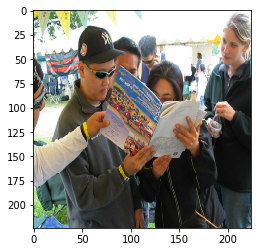

In [55]:
plt.imshow(i1[0])

In [58]:
generator_config['BATCH_SIZE'] = 25

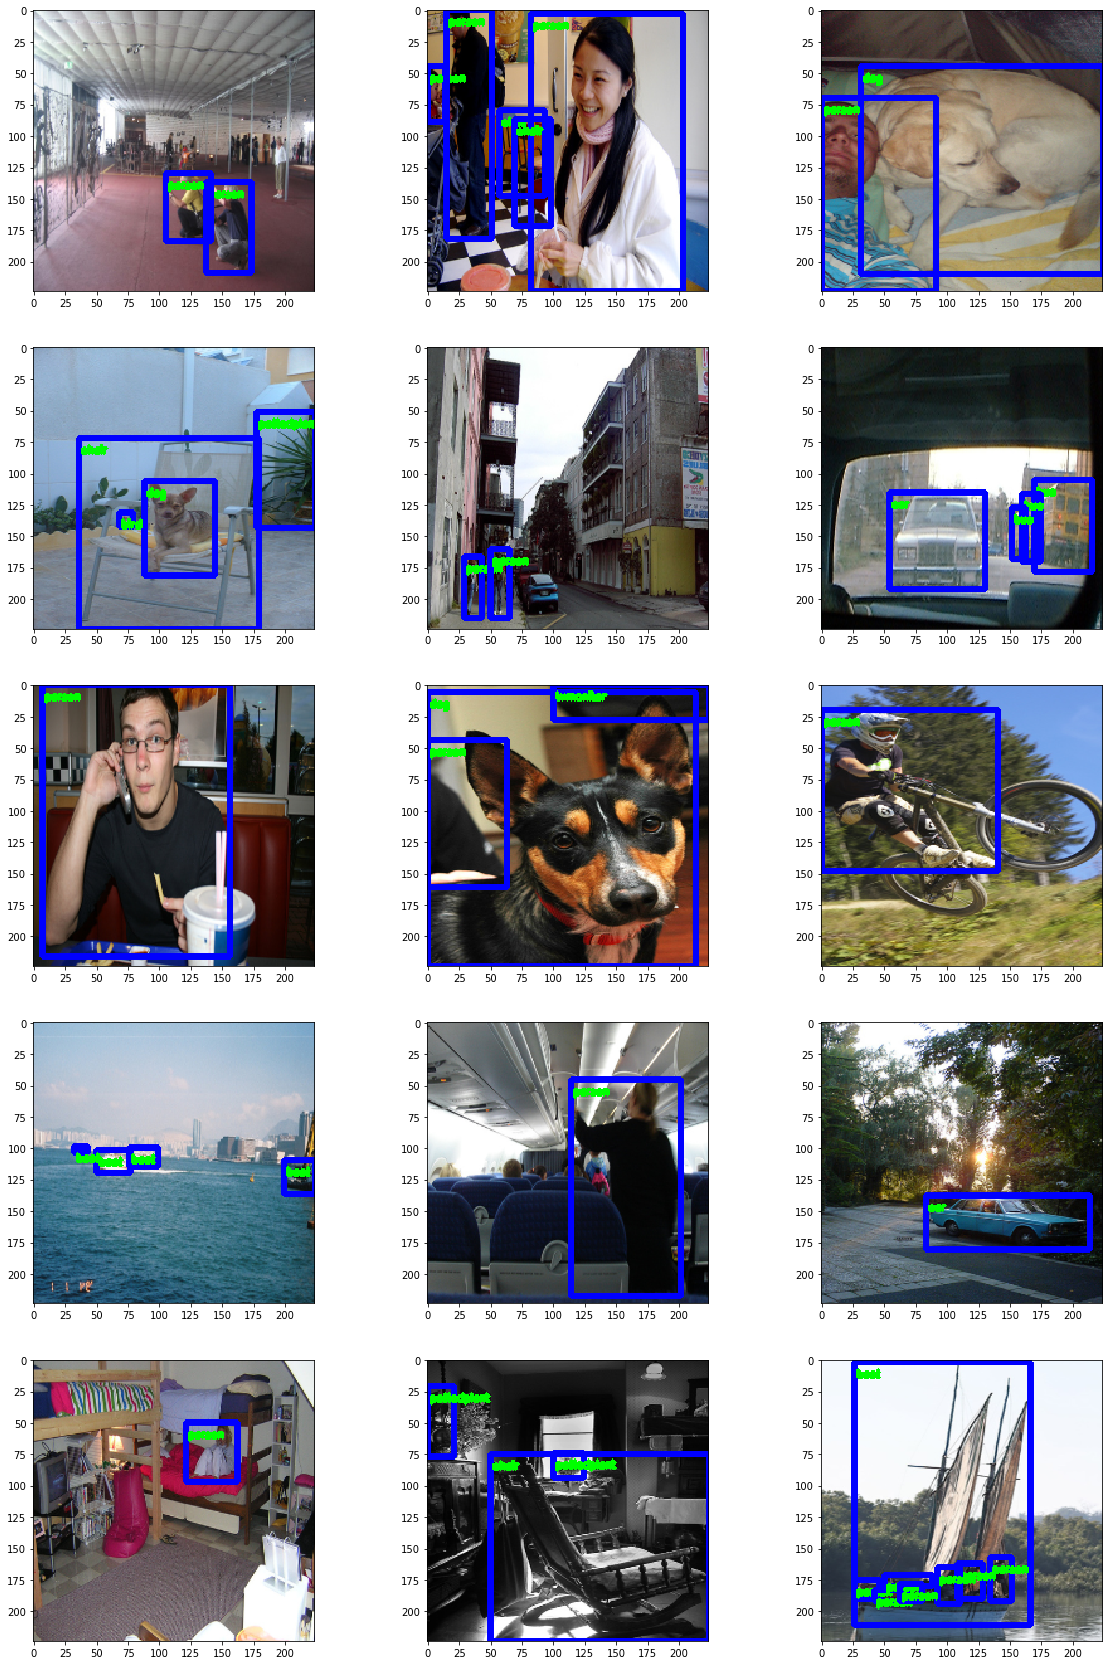

In [63]:
temp = BatchGenerator(train_imgs, generator_config, norm=None, jitter=True)
(i1, b1), g1 = temp.__getitem__(10)

fig, ax = plt.subplots(5,3, figsize=(20,30))
axes = ax.flatten()

for i in range(15):
#     idx = np.random.randint(16)
    axes[i].imshow(i1[i].astype(np.uint()))
plt.show()

# check available gpus

In [16]:
from tensorflow.python.client import device_lib

# def get_available_gpus():
#     local_device_protos = device_lib.list_local_devices()
#     return [x.name for x in local_device_protos if x.device_type == 'GPU']

# get_available_gpus()

In [22]:
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler


early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0.001, 
                           patience=5, 
                           mode='min', 
                           verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=2, 
                              min_lr=1e-8) 

# LOG_FILE_PATH = '../chkts/xception-base-{epoch:02d}-{val_loss:.4f}.hdf5'
LOG_FILE_PATH = '../chkts/xception-base.hdf5'

EPOCHS = 60


checkpoint = ModelCheckpoint(filepath=LOG_FILE_PATH, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True)


import tensorflow as tf
from keras.utils import multi_gpu_model
from keras.optimizers import Adam


with tf.device('/cpu:0'):
    model = build_model(input_image, true_boxes)
    print("built model successfully")
    
    
optimizer = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999)

GPUS = 3
parallel_model = multi_gpu_model(model, gpus=GPUS)
print("Successfully built {} GPUS model".format(GPUS))
parallel_model.compile(loss = custom_loss,
                       optimizer=optimizer)#,
print("building {} models...".format(GPUS))
EPOCHS = 50
print("let's start parallel model with 50 epochs")
parallel_model.fit_generator(generator        = train_batch,  
                             steps_per_epoch  = len(train_batch), 
                             epochs           = EPOCHS, 
                             verbose          = 1,
                             validation_data  = valid_batch,
                             validation_steps = len(valid_batch),
                             callbacks        = [reduce_lr, early_stop, checkpoint],
                             use_multiprocessing=True,
                             workers=5)



built model successfully


KeyboardInterrupt: 

In [23]:
parallel_model = multi_gpu_model(model, gpus=GPUS)
print("Successfully built {} GPUS model".format(GPUS))
parallel_model.compile(loss = custom_loss,
                       optimizer=optimizer)#,
print("building {} models...".format(GPUS))
parallel_model.load_weights('../chkts/xception-base.hdf5')

Successfully built 3 GPUS model
building 3 models...


IndexError: list index out of range

In [24]:

print("let's start parallel model again for another 50 epochs")
parallel_model.fit_generator(initial_epoch    = 0, 
                             generator        = train_batch, 
                             steps_per_epoch  = len(train_batch), 
                             epochs           = 50, 
                             verbose          = 1,
                             validation_data  = valid_batch,
                             validation_steps = len(valid_batch),
                             callbacks        = [early_stop, checkpoint, reduce_lr],
                             use_multiprocessing=True,
                             workers=8)


let's start parallel model again for another 50 epochs
Epoch 1/50
134/134 [==============================] - 253s 2s/step - loss: 12.1865 - val_loss: 7.5224

Epoch 00001: val_loss improved from inf to 7.52241, saving model to ../chkts/xception-base.hdf5
Epoch 2/50
134/134 [==============================] - 175s 1s/step - loss: 7.0600 - val_loss: 6.6569

Epoch 00002: val_loss improved from 7.52241 to 6.65693, saving model to ../chkts/xception-base.hdf5
Epoch 3/50
134/134 [==============================] - 172s 1s/step - loss: 6.3991 - val_loss: 6.0282

Epoch 00003: val_loss improved from 6.65693 to 6.02824, saving model to ../chkts/xception-base.hdf5
Epoch 4/50
134/134 [==============================] - 171s 1s/step - loss: 5.8157 - val_loss: 5.6646

Epoch 00004: val_loss improved from 6.02824 to 5.66459, saving model to ../chkts/xception-base.hdf5
Epoch 5/50
134/134 [==============================] - 174s 1s/step - loss: 5.3228 - val_loss: 5.1954

Epoch 00005: val_loss improved from 5.

In [ ]:

# print("let's start parallel model again for another 50 epochs")
# parallel_model.fit_generator(initial_epoch    = 2, 
#                              generator        = train_batch, 
#                              steps_per_epoch  = len(train_batch), 
#                              epochs           = 50, 
#                              verbose          = 1,
#                              validation_data  = valid_batch,
#                              validation_steps = len(valid_batch),
#                              callbacks        = [early_stop, checkpoint, reduce_lr],
#                              use_multiprocessing=True,
#                              workers=8)


let's start parallel model again for another 50 epochs
Epoch 3/50
134/134 [==============================] - 185s 1s/step - loss: 7.2998 - val_loss: 7.2926

Epoch 00003: val_loss improved from 7.93175 to 7.29261, saving model to ../chkts/xception-base.hdf5
Epoch 4/50
134/134 [==============================] - 173s 1s/step - loss: 6.8499 - val_loss: 6.7339

Epoch 00004: val_loss improved from 7.29261 to 6.73387, saving model to ../chkts/xception-base.hdf5
Epoch 5/50
134/134 [==============================] - 172s 1s/step - loss: 6.4813 - val_loss: 6.2890

Epoch 00005: val_loss improved from 6.73387 to 6.28900, saving model to ../chkts/xception-base.hdf5
Epoch 6/50
134/134 [==============================] - 173s 1s/step - loss: 6.1590 - val_loss: 6.1122

Epoch 00006: val_loss improved from 6.28900 to 6.11219, saving model to ../chkts/xception-base.hdf5
Epoch 7/50
134/134 [==============================] - 173s 1s/step - loss: 5.8971 - val_loss: 5.8690

Epoch 00007: val_loss improved from

In [25]:
np.save('../wts/weights_xception_coco_1.npy', model.get_weights())

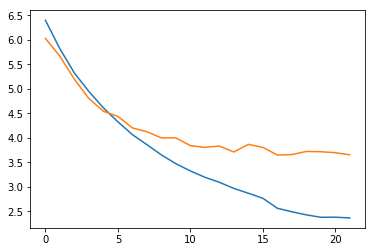

In [26]:
ls1 = parallel_model.history.history['loss']
val_ls1 = parallel_model.history.history['val_loss']
lr1 = parallel_model.history.history['lr']

plt.plot(ls1[2:])
plt.plot(val_ls1[2:])

In [ ]:
# parallel_model.history.history['loss']

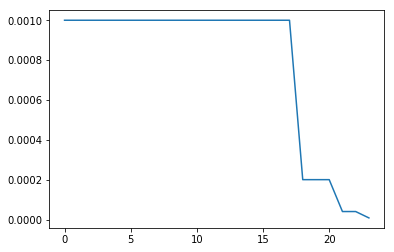

In [27]:
plt.plot(lr1)

In [31]:
lr1[-5:]

[0.00020000001, 0.00020000001, 4.0000003e-05, 4.0000003e-05, 8.0000009e-06]

# increase lr_rate

In [32]:
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999)
parallel_model.compile(loss = custom_loss,
                       optimizer=optimizer)#,

print("let's start parallel model again for another 50 epochs")
parallel_model.fit_generator(initial_epoch    = 25, 
                             generator        = train_batch, 
                             steps_per_epoch  = len(train_batch), 
                             epochs           = 75, 
                             verbose          = 1,
                             validation_data  = valid_batch,
                             validation_steps = len(valid_batch),
                             callbacks        = [early_stop, checkpoint, reduce_lr],
                             use_multiprocessing=True,
                             workers=8)


let's start parallel model again for another 50 epochs
Epoch 26/75
134/134 [==============================] - 221s 2s/step - loss: 2.5032 - val_loss: 3.7330

Epoch 00026: val_loss did not improve from 3.65086
Epoch 27/75
134/134 [==============================] - 175s 1s/step - loss: 2.4441 - val_loss: 3.7709

Epoch 00027: val_loss did not improve from 3.65086
Epoch 28/75
134/134 [==============================] - 174s 1s/step - loss: 2.3622 - val_loss: 3.7966

Epoch 00028: val_loss did not improve from 3.65086
Epoch 29/75
134/134 [==============================] - 174s 1s/step - loss: 2.2211 - val_loss: 3.5790

Epoch 00029: val_loss improved from 3.65086 to 3.57898, saving model to ../chkts/xception-base.hdf5
Epoch 30/75
134/134 [==============================] - 174s 1s/step - loss: 2.1704 - val_loss: 3.6018

Epoch 00030: val_loss did not improve from 3.57898
Epoch 31/75
134/134 [==============================] - 171s 1s/step - loss: 2.1347 - val_loss: 3.6349

Epoch 00031: val_loss d

In [33]:
np.save('../wts/weights_xception_coco_2.npy', model.get_weights())

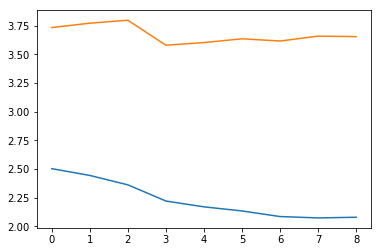

In [34]:
ls2 = parallel_model.history.history['loss']
val_ls2 = parallel_model.history.history['val_loss']
lr2 = parallel_model.history.history['lr']

plt.plot(ls2)
plt.plot(val_ls2)

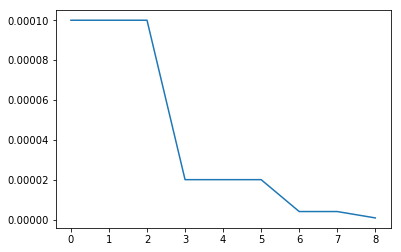

In [35]:
plt.plot(lr2)

In [36]:
optimizer = Adam(lr=0.5e-4, beta_1=0.9, beta_2=0.999)
parallel_model.compile(loss = custom_loss,
                       optimizer=optimizer)#,

print("let's start parallel model again for another 50 epochs")
parallel_model.fit_generator(initial_epoch    = 75, 
                             generator        = train_batch,                              steps_per_epoch  = len(train_batch), 
                             epochs           = 125, 
                             verbose          = 1,
                             validation_data  = valid_batch,
                             validation_steps = len(valid_batch),
                             callbacks        = [early_stop, checkpoint, reduce_lr],
                             use_multiprocessing=True,
                             workers=8)

let's start parallel model again for another 50 epochs
Epoch 76/125
134/134 [==============================] - 214s 2s/step - loss: 2.1203 - val_loss: 3.6137

Epoch 00076: val_loss did not improve from 3.57898
Epoch 77/125
134/134 [==============================] - 168s 1s/step - loss: 2.0679 - val_loss: 3.7323

Epoch 00077: val_loss did not improve from 3.57898
Epoch 78/125
134/134 [==============================] - 167s 1s/step - loss: 2.0306 - val_loss: 3.5288

Epoch 00078: val_loss improved from 3.57898 to 3.52876, saving model to ../chkts/xception-base.hdf5
Epoch 79/125
134/134 [==============================] - 165s 1s/step - loss: 1.9964 - val_loss: 3.6699

Epoch 00079: val_loss did not improve from 3.52876
Epoch 80/125
134/134 [==============================] - 168s 1s/step - loss: 1.9722 - val_loss: 3.6210

Epoch 00080: val_loss did not improve from 3.52876
Epoch 81/125
134/134 [==============================] - 165s 1s/step - loss: 1.9101 - val_loss: 3.5935

Epoch 00081: val_

In [37]:
np.save('../wts/weights_xception_coco_3.npy', model.get_weights())

In [38]:
ls3 = parallel_model.history.history['loss']
val_ls3 = parallel_model.history.history['val_loss']
lr3 = parallel_model.history.history['lr']

In [ ]:
# plt.plot(ls1+ls2+ls3)

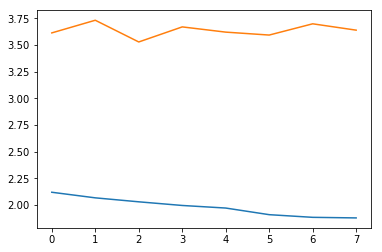

In [39]:
plt.plot(ls3)
plt.plot(val_ls3)

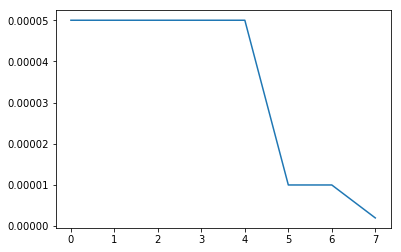

In [40]:
plt.plot(lr3)

In [41]:
optimizer = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999)
parallel_model.compile(loss = custom_loss,
                       optimizer=optimizer)#,

print("let's start parallel model again for another 50 epochs")
parallel_model.fit_generator(initial_epoch    = 125, 
                             generator        = train_batch,                              steps_per_epoch  = len(train_batch), 
                             epochs           = 150, 
                             verbose          = 1,
                             validation_data  = valid_batch,
                             validation_steps = len(valid_batch),
                             callbacks        = [early_stop, checkpoint, reduce_lr],
                             use_multiprocessing=True,
                             workers=8)

let's start parallel model again for another 50 epochs
Epoch 126/150
134/134 [==============================] - 223s 2s/step - loss: 1.8747 - val_loss: 3.6330

Epoch 00126: val_loss did not improve from 3.52876
Epoch 127/150
134/134 [==============================] - 174s 1s/step - loss: 1.8602 - val_loss: 3.6027

Epoch 00127: val_loss did not improve from 3.52876
Epoch 128/150
134/134 [==============================] - 175s 1s/step - loss: 1.8369 - val_loss: 3.6106

Epoch 00128: val_loss did not improve from 3.52876
Epoch 129/150
134/134 [==============================] - 177s 1s/step - loss: 1.8355 - val_loss: 3.7066

Epoch 00129: val_loss did not improve from 3.52876
Epoch 130/150
134/134 [==============================] - 174s 1s/step - loss: 1.8291 - val_loss: 3.6372

Epoch 00130: val_loss did not improve from 3.52876
Epoch 131/150
134/134 [==============================] - 176s 1s/step - loss: 1.8151 - val_loss: 3.6604

Epoch 00131: val_loss did not improve from 3.52876
Epoch 132

In [42]:
np.save('../wts/weights_xception_coco_4.npy', model.get_weights())

ls4 = parallel_model.history.history['loss']
val_ls4 = parallel_model.history.history['val_loss']
lr4 = parallel_model.history.history['lr']

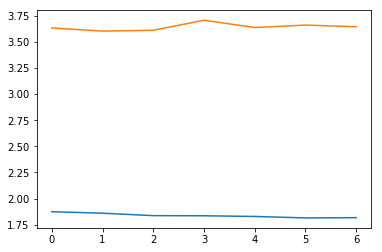

In [43]:
plt.plot(ls4)
plt.plot(val_ls4)

In [25]:
def predict(test_img, thresh=0.45):
#     thresh = 0.3
    image = cv2.imread(test_img)
    input_image = cv2.resize(image, (224, 224))
    input_image = input_image / 255.
    input_image = input_image[:,:,::-1]
    input_image = np.expand_dims(input_image, 0)

    dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))
    
    netout = parallel_model.predict([input_image, dummy_array])

    boxes = decode_netout(netout[0], 
                          obj_threshold=thresh,#OBJ_THRESHOLD,
                          nms_threshold=0.45,
                          anchors=ANCHORS, 
                          nb_class=CLASS)
    count = 1
    while not boxes:
        thresh = thresh -0.5*count
        boxes = decode_netout(netout[0], 
                              obj_threshold=thresh,#OBJ_THRESHOLD,
                              nms_threshold=0.3,
                              anchors=ANCHORS, 
                              nb_class=CLASS)
        count += 1
    if len(boxes)>1:
        score_ = boxes[0].get_score()
        index_  = 0
        for ii, bb in enumerate(boxes[1:]):
            score_1 = bb.get_score()
            if score_1>=score_:
                index_ = ii+1
                score_ = score_1
#         print(index_)
        return boxes[index_]
    else:
        return boxes

In [45]:
test_imgs = os.listdir('../../coco-data/VOCdevkit/VOC2012/JPEGImages/')

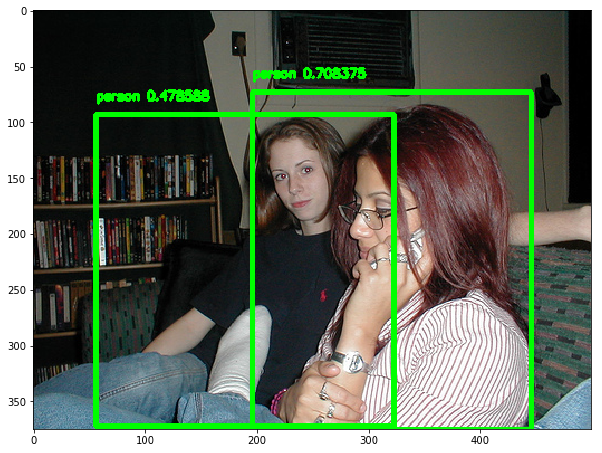

In [48]:
# now
ids = np.random.randint(len(test_imgs))
image = cv2.imread('../../coco-data/VOCdevkit/VOC2012/JPEGImages/' + test_imgs[ids])

dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

plt.figure(figsize=(10,10))


OBJ_THRESHOLD = 0.4
NMS_THRESHOLD = 0.45
input_image = cv2.resize(image, (224, 224))
input_image = input_image / 255.
input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)

netout = parallel_model.predict([input_image, dummy_array])

boxes = decode_netout(netout[0], 
                      obj_threshold=OBJ_THRESHOLD,
                      nms_threshold=NMS_THRESHOLD,
                      anchors=ANCHORS, 
                      nb_class=CLASS)
            
image = draw_boxes(image, boxes, labels=LABELS)

plt.imshow(image[:,:,::-1]); plt.show()

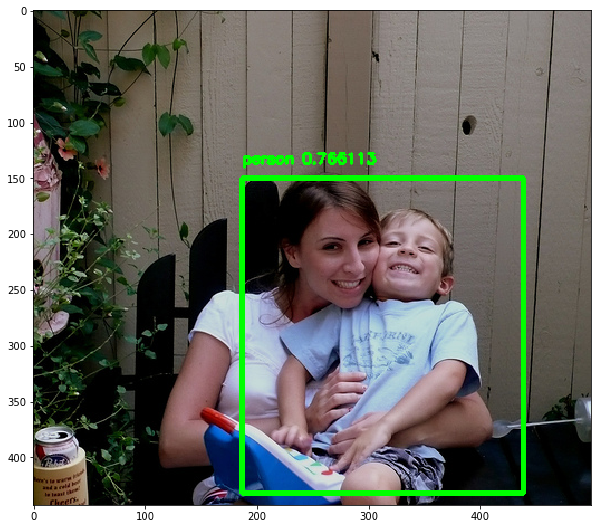

In [50]:
# now

ids = np.random.randint(len(test_imgs))
image = cv2.imread('../../coco-data/VOCdevkit/VOC2012/JPEGImages/' + test_imgs[ids])

dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

plt.figure(figsize=(10,10))


OBJ_THRESHOLD = 0.3
NMS_THRESHOLD = 0.45
input_image = cv2.resize(image, (224, 224))
input_image = input_image / 255.
input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)

netout = parallel_model.predict([input_image, dummy_array])

boxes = decode_netout(netout[0], 
                      obj_threshold=OBJ_THRESHOLD,
                      nms_threshold=NMS_THRESHOLD,
                      anchors=ANCHORS, 
                      nb_class=CLASS)
            
image = draw_boxes(image, boxes, labels=LABELS)

plt.imshow(image[:,:,::-1]); plt.show()

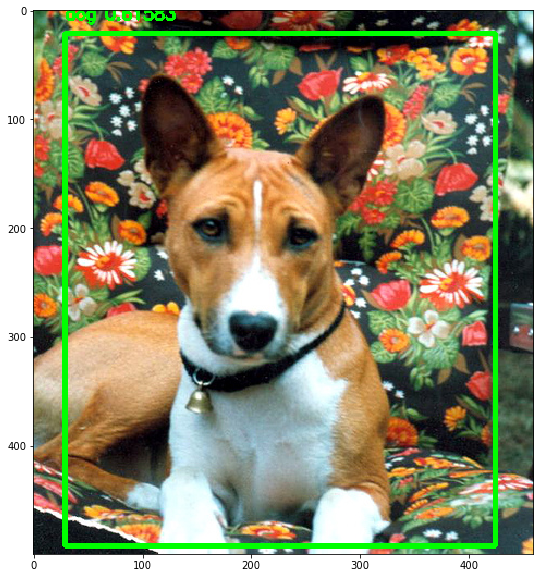

In [51]:
# now
ids = np.random.randint(len(test_imgs))
image = cv2.imread('../../coco-data/VOCdevkit/VOC2012/JPEGImages/' + test_imgs[ids])

dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

plt.figure(figsize=(10,10))


OBJ_THRESHOLD = 0.4
NMS_THRESHOLD = 0.45
input_image = cv2.resize(image, (224, 224))
input_image = input_image / 255.
input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)

netout = parallel_model.predict([input_image, dummy_array])

boxes = decode_netout(netout[0], 
                      obj_threshold=OBJ_THRESHOLD,
                      nms_threshold=NMS_THRESHOLD,
                      anchors=ANCHORS, 
                      nb_class=CLASS)
            
image = draw_boxes(image, boxes, labels=LABELS)

plt.imshow(image[:,:,::-1]); plt.show()

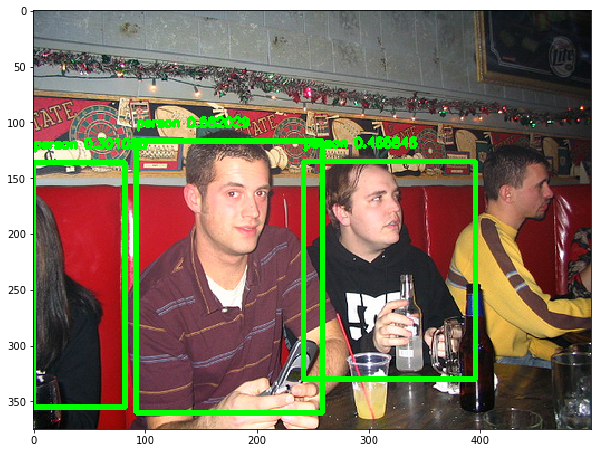

In [54]:
# now
ids = np.random.randint(len(test_imgs))
image = cv2.imread('../../coco-data/VOCdevkit/VOC2012/JPEGImages/' + test_imgs[ids])

dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

plt.figure(figsize=(10,10))


OBJ_THRESHOLD = 0.3
NMS_THRESHOLD = 0.45
input_image = cv2.resize(image, (224, 224))
input_image = input_image / 255.
input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)

netout = parallel_model.predict([input_image, dummy_array])

boxes = decode_netout(netout[0], 
                      obj_threshold=OBJ_THRESHOLD,
                      nms_threshold=NMS_THRESHOLD,
                      anchors=ANCHORS, 
                      nb_class=CLASS)
            
image = draw_boxes(image, boxes, labels=LABELS)

plt.imshow(image[:,:,::-1]); plt.show()

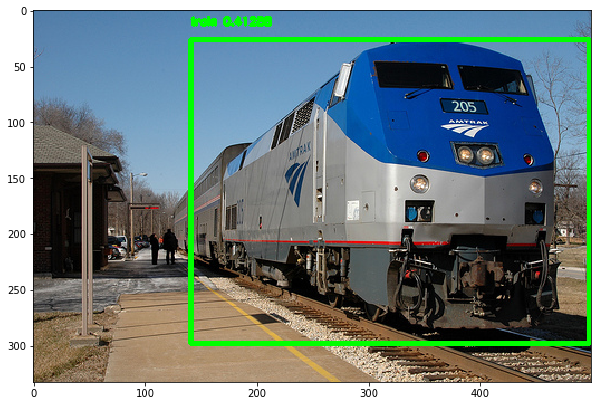

In [56]:
# now
ids = np.random.randint(len(test_imgs))
image = cv2.imread('../../coco-data/VOCdevkit/VOC2012/JPEGImages/' + test_imgs[ids])

dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

plt.figure(figsize=(10,10))


OBJ_THRESHOLD = 0.3
NMS_THRESHOLD = 0.45
input_image = cv2.resize(image, (224, 224))
input_image = input_image / 255.
input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)

netout = parallel_model.predict([input_image, dummy_array])

boxes = decode_netout(netout[0], 
                      obj_threshold=OBJ_THRESHOLD,
                      nms_threshold=NMS_THRESHOLD,
                      anchors=ANCHORS, 
                      nb_class=CLASS)
            
image = draw_boxes(image, boxes, labels=LABELS)

plt.imshow(image[:,:,::-1]); plt.show()

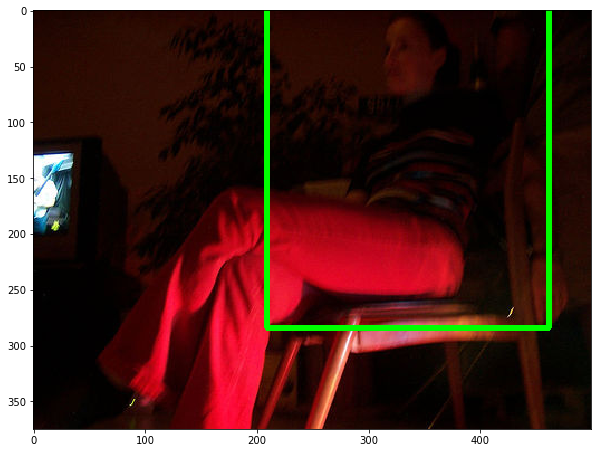

In [57]:
# now
ids = np.random.randint(len(test_imgs))
image = cv2.imread('../../coco-data/VOCdevkit/VOC2012/JPEGImages/' + test_imgs[ids])

dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

plt.figure(figsize=(10,10))


OBJ_THRESHOLD = 0.3
NMS_THRESHOLD = 0.45
input_image = cv2.resize(image, (224, 224))
input_image = input_image / 255.
input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)

netout = parallel_model.predict([input_image, dummy_array])

boxes = decode_netout(netout[0], 
                      obj_threshold=OBJ_THRESHOLD,
                      nms_threshold=NMS_THRESHOLD,
                      anchors=ANCHORS, 
                      nb_class=CLASS)
            
image = draw_boxes(image, boxes, labels=LABELS)

plt.imshow(image[:,:,::-1]); plt.show()

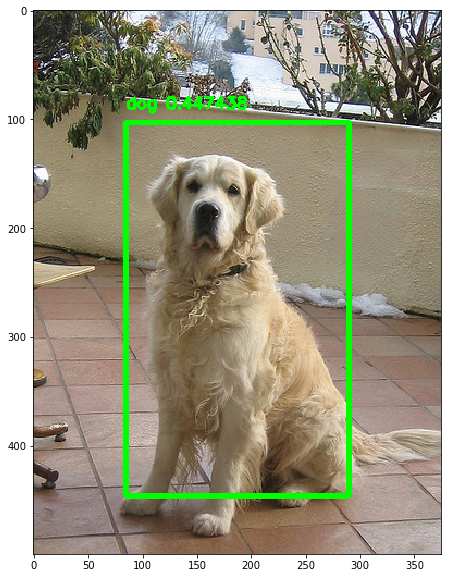

In [44]:
# now
image = cv2.imread('../../coco-data/VOCdevkit/VOC2012/JPEGImages/2010_000183.jpg')

dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

plt.figure(figsize=(10,10))


OBJ_THRESHOLD = 0.1
NMS_THRESHOLD = 0.45
input_image = cv2.resize(image, (224, 224))
input_image = input_image / 255.
input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)

netout = parallel_model.predict([input_image, dummy_array])

boxes = decode_netout(netout[0], 
                      obj_threshold=OBJ_THRESHOLD,
                      nms_threshold=NMS_THRESHOLD,
                      anchors=ANCHORS, 
                      nb_class=CLASS)
            
image = draw_boxes(image, boxes, labels=LABELS)

plt.imshow(image[:,:,::-1]); plt.show()

In [56]:
boxes[0].classes, boxes[1].classes

(array([0.27221778, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ], dtype=float32),
 array([0.8860882, 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       ],
       dtype=float32))

In [ ]:
def predict(test_img, thresh=0.3):
#     thresh = 0.3
    image = cv2.imread(test_img)
    input_image = cv2.resize(image, (224, 224))
    input_image = input_image / 255.
    input_image = input_image[:,:,::-1]
    input_image = np.expand_dims(input_image, 0)

    dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))
    
    netout = parallel_model.predict([input_image, dummy_array])

    boxes = decode_netout(netout[0], 
                          obj_threshold=thresh,#OBJ_THRESHOLD,
                          nms_threshold=0.3,
                          anchors=ANCHORS, 
                          nb_class=CLASS)
    count = 1
    while not boxes:
        thresh = thresh -0.5*count
        boxes = decode_netout(netout[0], 
                              obj_threshold=thresh,#OBJ_THRESHOLD,
                              nms_threshold=0.3,
                              anchors=ANCHORS, 
                              nb_class=CLASS)
        count += 1
    if len(boxes)>1:
        score_ = boxes[0].get_score()
        index_  = 0
        for ii, bb in enumerate(boxes[1:]):
            score_1 = bb.get_score()
            if score_1>=score_:
                index_ = ii+1
                score_ = score_1
#         print(index_)
        return boxes[index_]
    else:
        return boxes


import pandas as pd
box_pred = []

# test_dir = 'data/train/images/'
# df_test = pd.read_csv('data/level3_data/test.csv')
all_files = df_test['image_name'].values
print(len(all_files))


for ii, file_ in enumerate(all_files):
    box_pred.append(predict(test_dir + file_, 0.4))
    if (ii%2000) == 0:
        print("done till {} images".format(ii))
        
empty_pred_idx = []
box_pred_values = []
count = 0
for ii, box_ in enumerate(box_pred):
    image_h, image_w = 480, 640
#     if not box_:
#         print(ii)
#         count += 1
# count
    if box_:
        try:
#             print(box_[0])
            xmin = int(box_[0].xmin * image_w)
            ymin = int(box_[0].ymin * image_h)
            xmax = int(box_[0].xmax * image_w)
            ymax = int(box_[0].ymax * image_h)
        except:
#             print(box_)
            xmin = int(box_.xmin * image_w)
            ymin = int(box_.ymin * image_h)
            xmax = int(box_.xmax * image_w)
            ymax = int(box_.ymax * image_h)

    else:
        empty_pred_idx.append(ii)
        xmin, ymin, xmax, ymax = 999, 999, 999, 999#0, 0, 640, 480
        print("====",ii,"====")
    box_pred_values.append((xmin, ymin, xmax, ymax))
    
    if ii%2000 == 0:
        print("reached to {} boxes".format(ii))
    
box_pred_values = np.array(box_pred_values)
box_pred_values[3], box_pred_values.shape


df_pred = pd.DataFrame(columns=['x1','y1','x2','y2'], data=box_pred_values)
df_img = pd.DataFrame(data=all_files, columns=['image_name'])
sub = pd.concat([df_img, df_pred['x1'], df_pred['x2'], df_pred['y1'], df_pred['y2']], axis=1)
sub.head()




sub.x1 = np.where(sub.x1<-1,-1,sub.x1)
sub.y1 = np.where(sub.y1<-1, -1, sub.y1)
sub.x2 = np.where(sub.x2>640, 640, sub.x2)
sub.y2 = np.where(sub.y2>480, 480, sub.y2)

sub.to_csv('final-submission.csv',index=None)

print("done with prediction step")


In [ ]:
sub.head(10)

In [ ]:
fig, ax = plt.subplots(4,6,figsize=(20,12))
axes = ax.flatten()

for i in range(24):
    idx_r = np.random.randint(sub.shape[0])
    # now
    image = cv2.imread(test_dir + all_files[idx_r])
    box__ = sub.iloc[idx_r]
    xmin, ymin, xmax, ymax = box__['x1'], box__['y1'], box__['x2'],box__['y2']

    image = cv2.rectangle(image, (xmin,ymin), (xmax,ymax), (0,255,0), 3)
    axes[i].imshow(image[:,:,::-1])
plt.show()